Functional Strategy Profiles

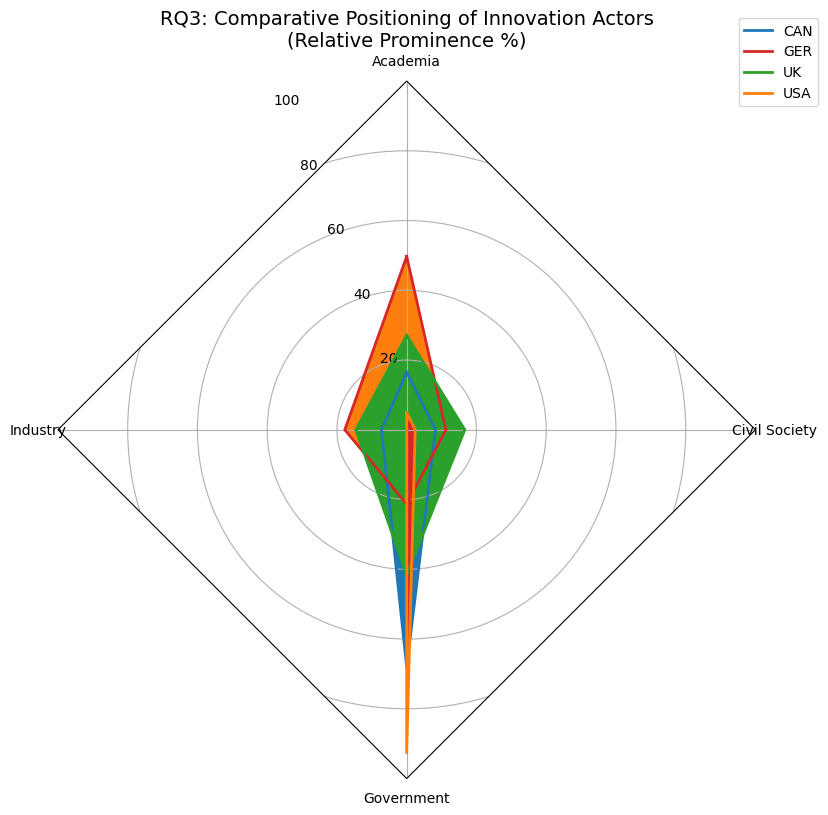

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, RegularPolygon
from matplotlib.path import Path
from matplotlib.projections.polar import PolarAxes
from matplotlib.projections import register_projection
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D

# 1. Load Data
df = pd.read_csv('entities_to_edit.csv') # Ensure this file is in the working directory

# 2. Filter & Process
relevant_actors = ['Academia', 'Industry', 'Government', 'Civil Society']
df_filtered = df[df['qh_category'].isin(relevant_actors)]

# Count frequencies
counts = df_filtered.groupby(['Country', 'qh_category']).size().reset_index(name='Frequency')
pivot_df = counts.pivot(index='qh_category', columns='Country', values='Frequency').fillna(0)

# Normalize to Percentages
pivot_pct = pivot_df.div(pivot_df.sum(axis=0), axis=1) * 100

# 3. Radar Chart Setup
def radar_factory(num_vars, frame='circle'):
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)
    class RadarAxes(PolarAxes):
        name = 'radar'
        RESOLUTION = 1
        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            self.set_theta_zero_location('N')
        def fill(self, *args, **closed):
            return super().fill(closed=True, *args)
        def plot(self, *args, **kwargs):
            lines = super().plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)
        def _close_line(self, line):
            x, y = line.get_data()
            if x[0] != x[-1]:
                x = np.append(x, x[0])
                y = np.append(y, y[0])
                line.set_data(x, y)
        def set_varlabels(self, labels):
            self.set_thetagrids(np.degrees(theta), labels)
        def _gen_axes_patch(self):
            return RegularPolygon((0.5, 0.5), num_vars, radius=0.5, edgecolor="k")
        def _gen_axes_spines(self):
            spine = Spine(axes=self, spine_type='circle', path=Path.unit_regular_polygon(num_vars))
            spine.set_transform(Affine2D().scale(.5).translate(.5, .5) + self.transAxes)
            return {'polar': spine}
    register_projection(RadarAxes)
    return theta

# 4. Plotting
categories = ['Academia', 'Industry', 'Government', 'Civil Society']
countries = ['CAN', 'GER', 'UK', 'USA']
colors = ['#1f77b4', '#d62728', '#2ca02c', '#ff7f0e'] # Blue, Red, Green, Orange

N = len(categories)
theta = radar_factory(N, frame='polygon')

fig, ax = plt.subplots(figsize=(9, 9), subplot_kw=dict(projection='radar'))
fig.subplots_adjust(top=0.85, bottom=0.05)

for i, country in enumerate(countries):
    # Get values for this country in the correct category order
    values = [pivot_pct.loc[cat, country] if cat in pivot_pct.index else 0 for cat in categories]
    ax.plot(theta, values, color=colors[i], label=country, linewidth=2)
    ax.fill(theta, values, facecolor=colors[i], alpha=0.1)

ax.set_rgrids([20, 40, 60, 80, 100])
ax.set_varlabels(categories)
ax.set_title('RQ3: Comparative Positioning of Innovation Actors\n(Relative Prominence %)', position=(0.5, 1.1), ha='center', size=14)
plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))

plt.show()

Data Loaded Successfully.


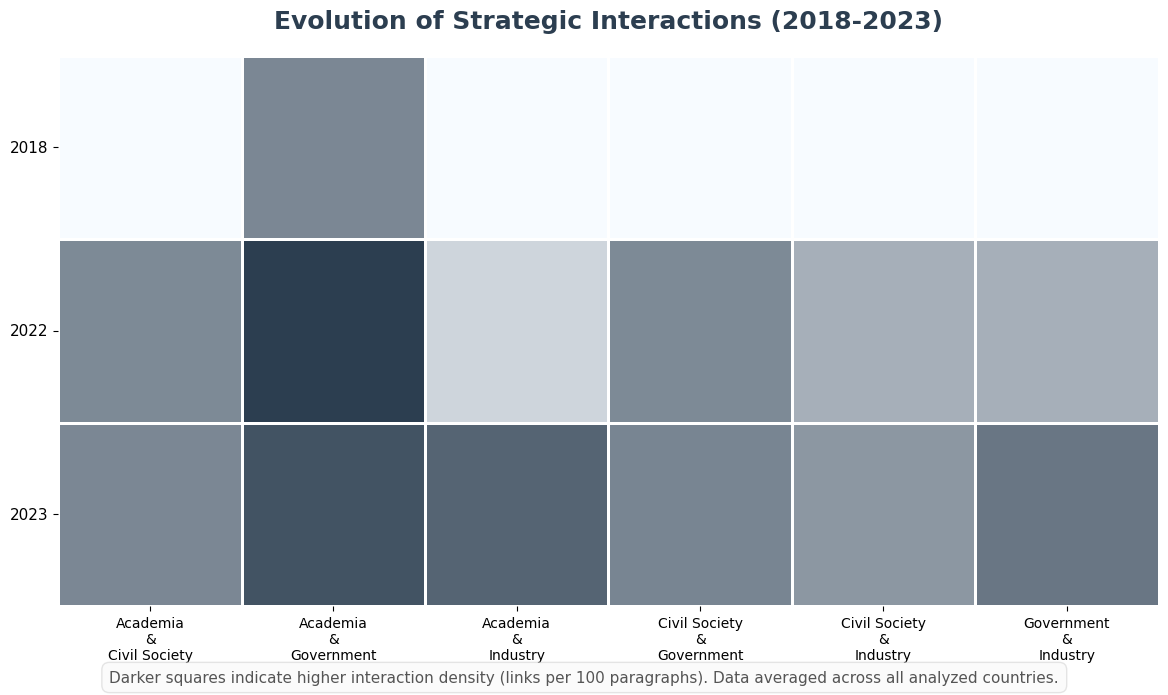

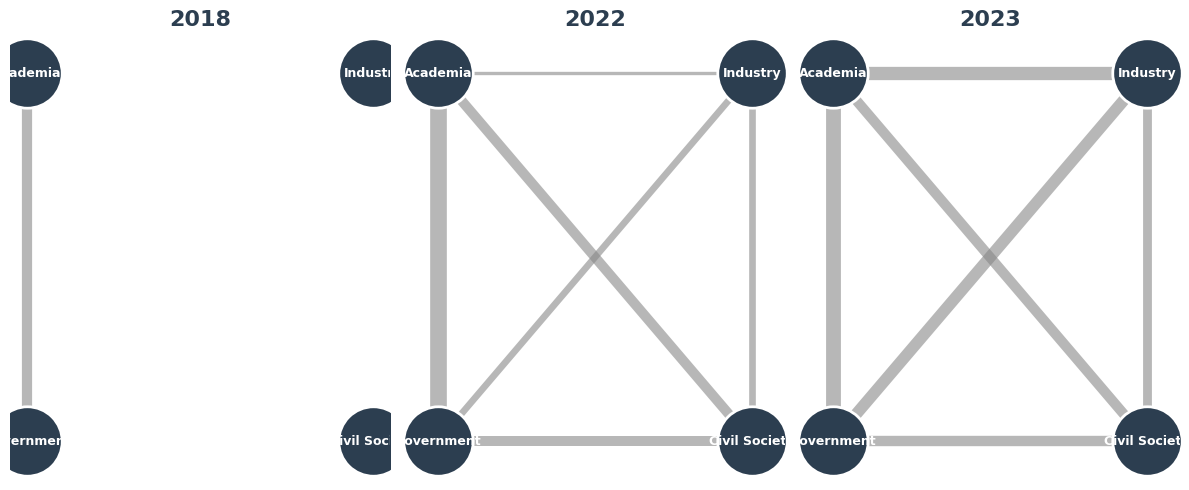

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import itertools
import matplotlib.colors as mcolors

# 1. SETUP & COLORS
# Define the clean Academic Slate Blue Palette
SLATE_DARK = "#2c3e50"
SLATE_LIGHT = "#f7fbff"
colors = [SLATE_LIGHT, SLATE_DARK] 
custom_cmap = mcolors.LinearSegmentedColormap.from_list("CustomSlate", colors)

# 2. LOAD DATA
try:
    entities_df = pd.read_csv("entities_to_edit.csv")
    output_df = pd.read_csv("output.csv")
    print("Data Loaded Successfully.")
except FileNotFoundError:
    print("Error: Files not found. Please ensure 'entities_to_edit.csv' and 'output.csv' exist.")
    exit()

# Filter for the 4 Helices
helices = ['Academia', 'Industry', 'Government', 'Civil Society']
# Normalize text
entities_df['qh_category'] = entities_df['qh_category'].astype(str).str.strip()
filtered = entities_df[entities_df['qh_category'].isin(helices)].copy()

# 3. METRICS CALCULATION
# A. Total Paragraphs per Country/Year (for normalization)
doc_stats = output_df.groupby(['Country', 'Year'])['Paragraph_ID'].nunique().reset_index()
doc_stats.columns = ['Country', 'Year', 'Total_Paragraphs']

# B. Interaction Pairs
all_pairs = list(itertools.combinations(sorted(helices), 2))
pair_labels = [f"{p[0]}-{p[1]}" for p in all_pairs]

def get_interactions(df):
    data = []
    # Group by Paragraph to find co-occurrences
    for (country, year, p_id), group in df.groupby(['Country', 'Year', 'Paragraph_ID']):
        cats = sorted(list(set(group['qh_category'].tolist())))
        if len(cats) >= 2:
            for c1, c2 in itertools.combinations(cats, 2):
                data.append({'Country': country, 'Year': year, 'Pair': f"{c1}-{c2}"})
    return pd.DataFrame(data)

inter_df = get_interactions(filtered)

if inter_df.empty:
    print("No interactions found.")
    exit()

inter_counts = inter_df.groupby(['Country', 'Year', 'Pair']).size().reset_index(name='Count')

# Pivot
inter_pivot = inter_counts.pivot(index=['Country', 'Year'], columns='Pair', values='Count').fillna(0).reset_index()

# Ensure all columns exist
for p in pair_labels:
    if p not in inter_pivot.columns:
        inter_pivot[p] = 0

# Merge and Normalize
inter_pivot = inter_pivot.merge(doc_stats, on=['Country', 'Year'])
norm_cols = []
for p in pair_labels:
    col_name = f"Density_{p}"
    # Calculate Interactions per 100 Paragraphs
    inter_pivot[col_name] = (inter_pivot[p] / inter_pivot['Total_Paragraphs']) * 100
    norm_cols.append(col_name)

# Yearly Summary (Mean across all countries)
yearly_summary = inter_pivot.groupby('Year')[norm_cols].mean()


# --- PLOT 1: EVOLUTION HEATMAP (Styled) ---
plt.figure(figsize=(12, 7))

# Clean column names for display
heatmap_data = yearly_summary.copy()
heatmap_data.columns = [c.replace('Density_', '').replace('-', '\n&\n') for c in heatmap_data.columns]

ax = sns.heatmap(
    heatmap_data, 
    annot=False,            # Clean look (no numbers)
    cmap=custom_cmap,       # Your custom Slate Blue theme
    cbar=False,             # Removed scale bar
    linewidths=1, 
    linecolor='white',      # White grid lines
    square=True             # Boxy look
)

# Styling
plt.title("Evolution of Strategic Interactions (2018-2023)", fontsize=18, fontweight='bold', color=SLATE_DARK, pad=20)
plt.xlabel("", fontweight='bold')
plt.ylabel("", fontweight='bold')
plt.yticks(rotation=0, fontsize=11)
plt.xticks(rotation=0, fontsize=10)

# Footer
plt.figtext(
    0.5, 0.02, 
    "Darker squares indicate higher interaction density (links per 100 paragraphs). Data averaged across all analyzed countries.", 
    ha="center", fontsize=11, color="#555555",
    bbox=dict(facecolor='#f9f9f9', alpha=0.5, boxstyle='round,pad=0.5', edgecolor='#cccccc')
)

plt.tight_layout(rect=[0, 0.08, 1, 0.95])
plt.show()


# --- PLOT 2: NETWORK TIMELINE (Styled) ---
years = sorted(yearly_summary.index.tolist())
fig, axes = plt.subplots(1, len(years), figsize=(4 * len(years), 5))

# Fixed Layout
pos = {
    'Academia': (0, 1),
    'Industry': (1, 1),
    'Government': (0, 0),
    'Civil Society': (1, 0)
}

global_max_weight = yearly_summary.max().max()

for i, year in enumerate(years):
    # Handle single subplot case
    ax = axes[i] if len(years) > 1 else axes
    
    G = nx.Graph()
    G.add_nodes_from(helices)
    
    # Add edges
    row = yearly_summary.loc[year]
    for p in pair_labels:
        u, v = p.split('-')
        weight = row[f'Density_{p}']
        if weight > 0:
            G.add_edge(u, v, weight=weight)
    
    # Draw Nodes (Matching Slate Blue)
    nx.draw_networkx_nodes(
        G, pos, ax=ax, 
        node_color=SLATE_DARK,  # Use the theme color
        node_size=2500, 
        edgecolors='white',     # White border
        linewidths=2
    )
    
    # Draw Edges
    if len(G.edges()) > 0:
        edges = G.edges(data=True)
        widths = [d['weight'] * (12 / global_max_weight) for u, v, d in edges]
        nx.draw_networkx_edges(G, pos, ax=ax, width=widths, edge_color='#888888', alpha=0.6)
    
    # Labels
    nx.draw_networkx_labels(G, pos, ax=ax, font_size=9, font_weight='bold', font_color='white', font_family='sans-serif')
    
    ax.set_title(f"{year}", size=16, fontweight='bold', color=SLATE_DARK)
    ax.axis('off')

plt.tight_layout()
plt.show()

Co-Occurence Probabilities